# Image Processing - Tracks&Roads detection


Idea: 
- create BI, BI2, ... image 
- trhresholding + filtering


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import sys
sys.path.append("../common/")

In [4]:
from data_utils import GRID_SIZE, TRAIN_WKT, LABELS, get_resized_polygons, TRAIN_IMAGE_IDS, ALL_IMAGE_IDS
from image_utils import get_image_data, generate_pansharpened, generated_upsampled_swir, generate_label_image
from image_utils import get_common_size, generate_aligned_swir
from visu_utils import display_img_1b, display_img_3b, display_img_8b, display_labels, plt_st
from preprocessing_utils import create_pan_rad_inds_ms, create_pan_ms_swir
from postprocessing_utils import normalize, binarize

In [5]:
def score(y_true, y_pred):
    smooth = 1e-12
    if len(y_true.shape) == 2: 
        y_true = y_true[:,:,None]    
    if len(y_pred.shape) == 2: 
        y_pred = y_pred[:,:,None]        
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred, axis=(0, 1))
    sum_ = np.sum(y_true + y_pred, axis=(0, 1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

In [6]:
from otb_preprocessing import compute_rm_indices_image

In [7]:
from data_utils import get_image_ids
gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
track_train = get_image_ids([3,4], gb)

```
Web : Coastal, Blue, Green, Yellow, Red, Red Edge, Near-IR1, Near-IR2
         1       2    3       4      5      6          7        8
         0       1    2       3      4      5          6        7   
```         

In [133]:
# user_channels_dict = {
#     'red': ('3b', 0),
#     'green': ('3b', 1), 
#     'blue': ('3b', 2),
#     'nir': ('ms', 7),
#     'mir': ('swir', 1)
# }

# user_channels_dict = {
#     'red': ('3b', 0),
#     'green': ('3b', 1), 
#     'blue': ('3b', 2),
#     'nir': ('ms_pan', 6),
#     'mir': ('ms_pan', 7)
# }

user_channels_dict = {
    'red': ('ms', 4),
    'green': ('ms', 2), 
    'blue': ('ms', 1),
    'nir': ('ms', 6),
    'mir': ('ms', 7)
}

In [10]:
def load_data(dataset, no_labels=False):
    rad_indcs_imgs = []
    y_true_list = []
    
    for i, image_id in enumerate(dataset):
        print "--", image_id, i+1, "/", len(dataset)
        rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    
        rad_indcs_imgs.append(rad_indcs_img)

        if not no_labels:
            label_image = get_image_data(image_id, 'label')
            y_true = label_image[:,:,7]
        else:
            y_true = get_image_data(image_id, 'pan')
            
        y_true = cv2.resize(y_true, dsize=(rad_indcs_img.shape[1], rad_indcs_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        y_true_list.append(y_true) 
        
    return rad_indcs_imgs, y_true_list

## Development stuff

In [11]:
def compute_normalized_band_product(img):
    band_prod = normalize(img[:,:,0])
    for i in range(img.shape[2]-1):
        band_prod *= normalize(img[:,:,i+1])
    return band_prod[:,:,None]

def compute_band_product(img):
    band_prod = img[:,:,0].copy()
    for i in range(img.shape[2]-1):
        band_prod *= img[:,:,i+1]
    return band_prod[:,:,None]


def compute_band_sum(img):
    band_prod = img[:,:,0].copy()
    for i in range(img.shape[2]-1):
        band_prod += img[:,:,i+1]
    return band_prod[:,:,None]


# band_prod = compute_normalized_band_product(rad_indcs_img)

Tryout REIndex from http://www.sciencedirect.com/science/article/pii/S111098231400043X

$REI=(NIR2−B)/(NIR2+B×NIR2)$

In [12]:
def compute_REI_ms(image_id):
    img_ms = get_image_data(image_id, 'ms')    
    nir2 = img_ms[:,:,7].astype(np.float32)
    b = img_ms[:,:,1].astype(np.float32)
    rei = (nir2 - b)/(nir2 + b * nir2)
    return rei

In [13]:
image_id = track_train[2]

In [138]:
img_ms = get_image_data(image_id, 'ms')
nir = img_ms[:,:,6].astype(np.float32)
nir2 = img_ms[:,:,7].astype(np.float32)
b = img_ms[:,:,1].astype(np.float32)
c = img_ms[:,:,0].astype(np.float32)
g = img_ms[:,:,2].astype(np.float32)
y = img_ms[:,:,3].astype(np.float32)
# x1 = b/(nir2 + 0.00001)
# x2 = b * nir2

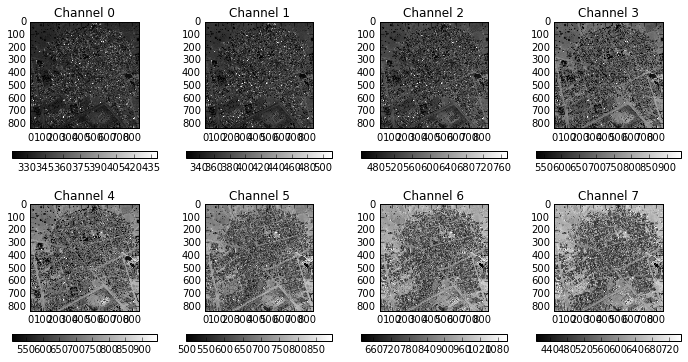

In [124]:
plt_st(12, 6)
display_img_8b(img_ms)

In [134]:
channels = ['bi', 'bi2', 'ci', 'ri']

rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    

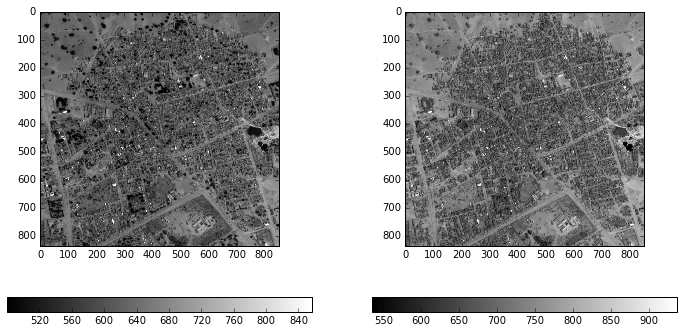

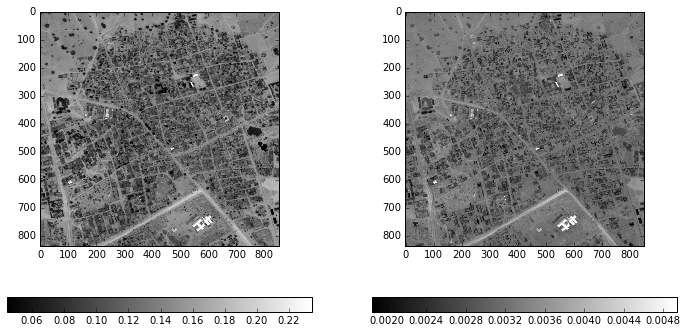

In [135]:
plt_st(12, 6)
plt.subplot(121)
display_img_1b(rad_indcs_img[:,:,0])
plt.subplot(122)
display_img_1b(rad_indcs_img[:,:,1])

plt_st(12, 6)
plt.subplot(121)
display_img_1b(rad_indcs_img[:,:,2])
plt.subplot(122)
display_img_1b(rad_indcs_img[:,:,3])

In [139]:
x1 = nir2 - g
x2 = nir2 + g * nir2

#rei = (nir2 - b) / (nir2 + b * nir)
rei = x1 / (x2 + 0.00001)
bai = (b - nir) / (b + nir)

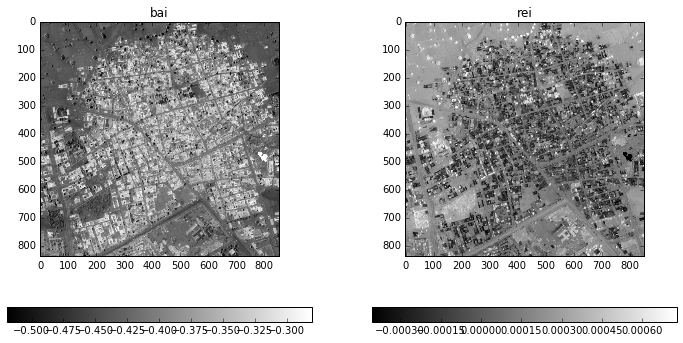

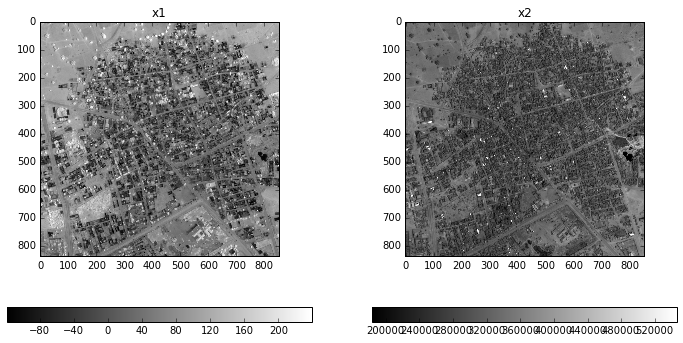

In [140]:
# plt_st(12, 6)
# plt.subplot(121)
# display_img_1b(nir2_)
# plt.title("nir2")
# plt.subplot(122)
# display_img_1b(b_)
# plt.title("b")

plt_st(12, 6)
plt.subplot(121)
display_img_1b(bai)
plt.title("bai")
plt.subplot(122)
display_img_1b(rei)
plt.title("rei")


plt_st(12, 6)
plt.subplot(121)
display_img_1b(x1)
plt.title("x1")
plt.subplot(122)
display_img_1b(x2)
plt.title("x2")

Optimum search for each radiometric index

In [13]:
# channels = ['ndwi2',]
channels = ['ndwi2', 'mndwi', 'bi']

In [14]:
LABELS

['None',
 'Buildings',
 'Misc. Manmade structures',
 'Road',
 'Track',
 'Trees',
 'Crops',
 'Waterway',
 'Standing water',
 'Vehicle Large',
 'Vehicle Small']

In [15]:
from preprocessing_utils import water_index_ms, water_index_2_ms

In [31]:
# Load all permanent data

rad_indcs_imgs = []
y_true_list = []

other_train_ids = TRAIN_IMAGE_IDS
# other_train_ids = water_train
dataset = tuple(water_train) + ("6040_2_2", "6110_4_0", "6110_1_2") #+ tuple(other_train_ids[:5])

for i, image_id in enumerate(dataset):
    print "--", image_id, i+1, "/", len(dataset)
#     generate_pansharpened(image_id, 'ms')
#     generate_aligned_swir(image_id)
#     generated_upsampled_swir(image_id, 'swir_aligned')

    rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict)    

    # inverse ndpi
    #ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
    #rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi
        
    #wi = water_index_ms(image_id)
    #rad_indcs_img = np.concatenate((rad_indcs_img, wi[:,:,None]), axis=2)
    
    wi2 = water_index_2_ms(image_id)
    rad_indcs_img = np.concatenate((rad_indcs_img, wi2[:,:,None]), axis=2)
    
#     # compute mixed bands with ci
#     alpha = 0.5
#     ci = rad_indcs_img[:,:,channels.index('ci')]
#     ci = ci.max() + ci.min() - ci
#     bands = [rad_indcs_img[:,:,channels.index(c)] for c in channels[:-1]]
#     for b in bands: # without ci and prod 
#         b -= ci
#         rad_indcs_img = np.concatenate((rad_indcs_img, b[:,:,None]), axis=2)
        
    # concatenate bands sum:
    #bands_op = compute_normalized_band_product(rad_indcs_img[:,:,:])
    #rad_indcs_img = np.concatenate((rad_indcs_img, bands_op), axis=2)

    rad_indcs_imgs.append(rad_indcs_img)
    
    label_image = get_image_data(image_id, 'label')
    y_true = label_image[:,:,7]# + label_image[:,:,8]
    y_true = cv2.resize(y_true, dsize=(rad_indcs_img.shape[1], rad_indcs_img.shape[0]), interpolation=cv2.INTER_LINEAR)
    y_true_list.append(y_true)

-- 6070_2_3 1 / 5
-- 6100_2_2 2 / 5
-- 6040_2_2 3 / 5
-- 6110_4_0 4 / 5
-- 6110_1_2 5 / 5


In [ ]:
count = 0

In [ ]:
_channels = tuple(channels) + ('wi', ) 
for i, image_id in enumerate(dataset[count:]):
    i += count
    print "--", image_id, i, "/", len(water_train)

    plt_st(12,6)
    display_img_1b(y_true_list[i], clim=[0, 1])
    plt.title("Label")
    m = 2 
    for j in range(rad_indcs_imgs[i].shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,m,j % m + 1)
        plt.title("%s" % _channels[j])
        display_img_1b(rad_indcs_imgs[i][:,:,j])
    break
count+=1

In [29]:
count=2

-- 6100_2_2 1 / 2


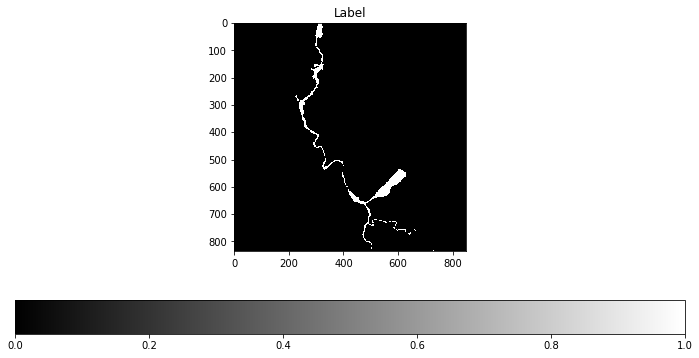

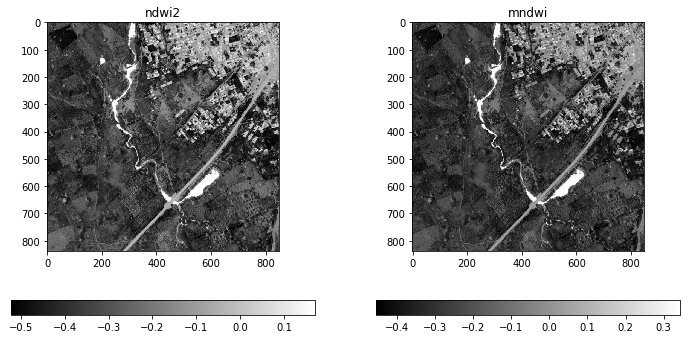

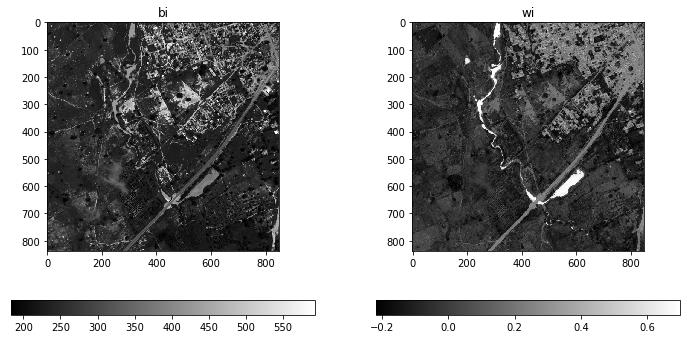

In [20]:
_channels = tuple(channels)  + ('wi', ) 
for i, image_id in enumerate(dataset[count:]):
    i += count
    print "--", image_id, i, "/", len(water_train)

    plt_st(12,6)
    display_img_1b(y_true_list[i], clim=[0, 1])
    plt.title("Label")
    m = 2 
    for j in range(rad_indcs_imgs[i].shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,m,j % m + 1)
        plt.title("%s" % _channels[j])
        display_img_1b(rad_indcs_imgs[i][:,:,j])
    break
count+=1

In [461]:
total_score = 0

index = 0
t1, t2, size, iters = (0.049999999999999933, 0.29999999999999988, 41.8, 6)

for i, image_id in enumerate(water_train):
    print "--", image_id, i, "/", len(water_train)
    y_true = y_true_list[i]
    ri_img = rad_indcs_imgs[i][:,:,index]    
    h, w = get_common_size(y_true, ri_img)    
    bin_img = binarize(ri_img, t1, t2, size, iters)
    s = score(y_true[:h,:w], bin_img[:h,:w])    
    print "Score: ",s
    total_score += s

total_score /= len(water_train)
print "Total score : ", total_score

-- 6070_2_3 0 / 2
Score:  0.748055
-- 6100_2_2 1 / 2
Score:  0.570332
Total score :  0.659193754196


In [ ]:
-- 6070_2_3 0 / 4
Score:  0.78683
-- 6100_2_2 1 / 4
Score:  0.522502
-- 6110_4_0 2 / 4
Score:  4.26858e-17
-- 6110_1_2 3 / 4
Score:  2.01613e-16
Total score :  0.327333107591

Brute-force search

In [472]:
from scipy import optimize

index = 5
t_min = 0.3
t_max = 2.0

def func(params):
    t1, t2 = params
    size = 55
    iters = 5
    total_score = 0
    for i, image_id in enumerate(water_train):        
        y_true = y_true_list[i]
        ri_img = rad_indcs_imgs[i][:,:,index]
        h, w = get_common_size(y_true, ri_img)    
        bin_img = binarize(ri_img, t1, t2, size, int(iters))
        s = score(y_true[:h,:w], bin_img[:h,:w])
        total_score += s
    total_score /= len(water_train)
    return total_score

def func2(_params):
    size, iters = _params
    t1, t2, _, _ = params[index]
    total_score = 0
    for i, image_id in enumerate(water_train):        
        y_true = y_true_list[i]
        ri_img = rad_indcs_imgs[i][:,:,index]
        h, w = get_common_size(y_true, ri_img)    
        bin_img = binarize(ri_img, t1, t2, size, int(iters))
        s = score(y_true[:h,:w], bin_img[:h,:w])
        total_score += s
    total_score /= len(water_train)
    return total_score

def bruteforce_search(func, t_range):
    fmax = 0
    res = None
    for i, t1 in enumerate(t_range[:-1]):
        for t2 in t_range[i+1:]:
            s = func((t1, t2))
            if s > fmax:
                res = (t1, t2)
                fmax = s
    return res, fmax

print optimize.brute(func2,(slice(10, 30, 1), slice(1,5,1)), full_output=False, finish=optimize.fmin)
# resbrute = optimize.brute(func,(slice(0.0, 0.3, 0.01), slice(0.3, 0.9, 0.025)), full_output=True, finish=optimize.fmin)
#print bruteforce_search(func, np.arange(t_min, t_max, 0.025))

[ 10.   1.]


In [260]:
func((0.14999999999999991, 0.42499999999999988))

0.5653005987405777

In [44]:
params = {    
    0: (0.05, 0.3, 41.8, 6),
    1: (0.15, 0.425, 17.5, 6),
    2: (0.175, 0.45, 43, 6),
    3: (0.225, 0.5, 39.9, 5),
    4: (1.1, 2.5, 30, 5),
    5: (0.225, 0.65, 30, 5),    
}

def water_detector(rad_indcs_img): 
    weights = [1, 1, 1, 1, 1, 1]
    indices = list(range(rad_indcs_img.shape[2]))
    indices.remove(0)
    sum_img = binarize(rad_indcs_img[:,:,0], *params[0])
    for i in indices:
        sum_img += weights[i] * binarize(rad_indcs_img[:,:,i], *params[i])
    result = (sum_img > 0.55 * rad_indcs_img.shape[2]).astype(np.uint8)
    return result
    
    
total_score = 0
for i, image_id in enumerate(dataset):
    print "--", image_id, i, "/", len(dataset)    
    y_true = y_true_list[i]
    bin_img = water_detector(rad_indcs_imgs[i])
    h, w = get_common_size(y_true, bin_img)    
    s = score(y_true[:h,:w], bin_img[:h,:w])
    print "Score: ",s
    total_score += s
total_score /= len(dataset)
print "Total score : ", total_score

-- 6070_2_3 0 / 5
Score:  0.743229
-- 6100_2_2 1 / 5
Score:  0.570869
-- 6040_2_2 2 / 5
Score:  1.0
-- 6110_4_0 3 / 5
Score:  2.29991e-16
-- 6110_1_2 4 / 5
Score:  1.0
Total score :  0.662819588184


-- 6070_2_3 0 / 4
Score:  0.779659
-- 6100_2_2 1 / 4
Score:  0.570048
-- 6110_4_0 2 / 4
Score:  1.82983e-16
-- 6110_1_2 3 / 4
Score:  1.0
Total score :  0.587426707149

-- 6070_2_3 0 / 2
Score:  0.784617
-- 6100_2_2 1 / 2
Score:  0.550641
Total score :  0.667628586292

In [72]:
count = 0

-- 6070_2_3 2 / 5


NameError: name 'water_detector' is not defined

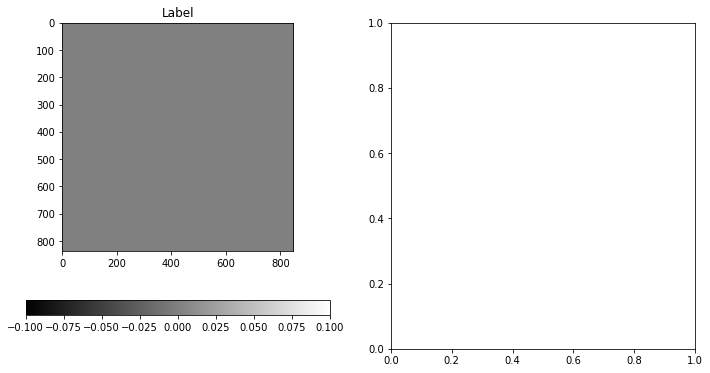

In [21]:
_channels = tuple(channels) + ('bi', )

for i, image_id in enumerate(dataset):
    i += count
    print "--", image_id, i, "/", len(dataset)
    plt_st(12,6)
    plt.subplot(121)
    display_img_1b(y_true_list[i])
    plt.title("Label")
    plt.subplot(122)
    display_img_1b(water_detector(rad_indcs_imgs[i]))
    m = 2 
    for j in range(rad_indcs_imgs[i].shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,m,j % m + 1)
        plt.title("%s" % _channels[j])
        t1, t2, size, iters = params[j]
        bin_img = binarize(rad_indcs_imgs[i][:,:,j], t1, t2, size, iters)
        display_img_1b(bin_img)
    break
count+=1

In [32]:
# dataset = water_train
# dataset = waterway_test
# dataset = other_train_ids
rad_indcs_imgs, y_true_list = load_data(dataset, no_labels=True)

NameError: name 'waterway_test' is not defined

In [144]:
params = {    
    0: (0.175, 999, 10, 1),
    1: (0.1, 999, 10, 1),
    2: (0.1, 999, 10, 1),
    3: (0.3, 999, 10, 1),
    4: (1.0, 2.5, 10, 1),
    5: (0.225, 0.65, 10, 1),    
}


def water_detector(rad_indcs_img): 
    weights = [1, 1, 1, 1, 1, 1]
    indices = list(range(rad_indcs_img.shape[2]))
    indices.remove(0)
    sum_img = binarize(rad_indcs_img[:,:,0], *params[0])
    for i in indices:
        sum_img += weights[i] * binarize(rad_indcs_img[:,:,i], *params[i])
    result = (sum_img > 0.25 * rad_indcs_img.shape[2]).astype(np.uint8)
    return result
    

In [150]:
count = 4

-- 6080_4_3 4 / 6


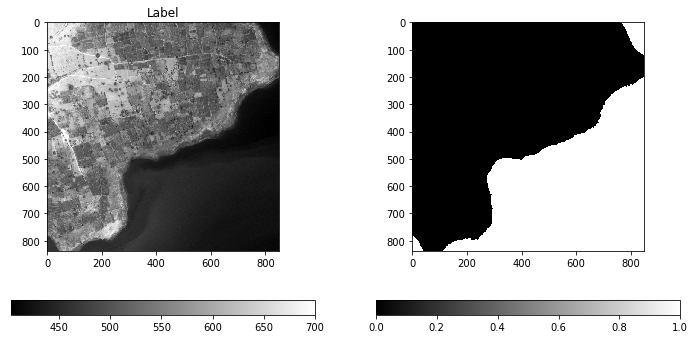

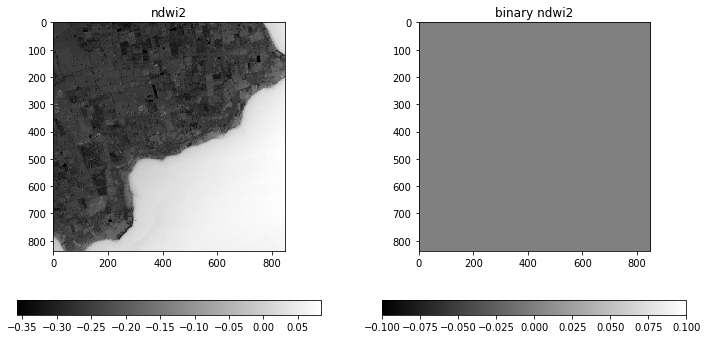

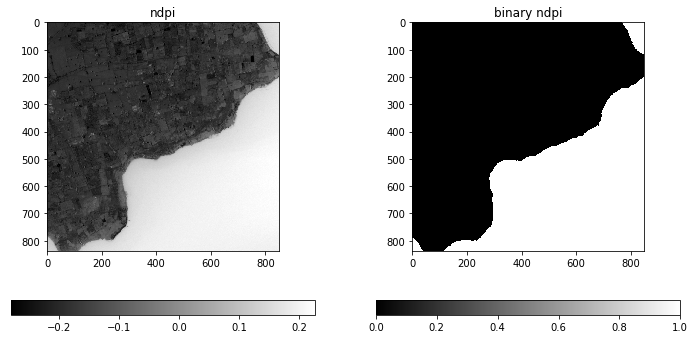

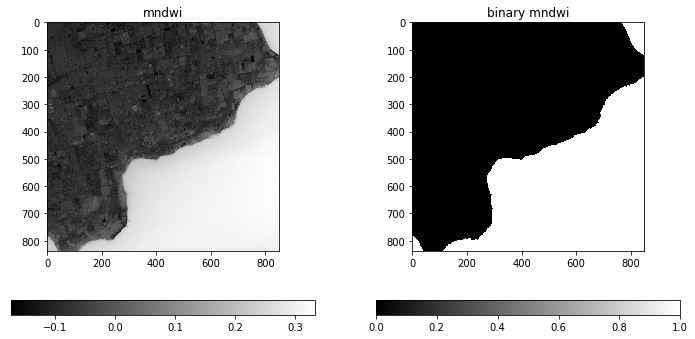

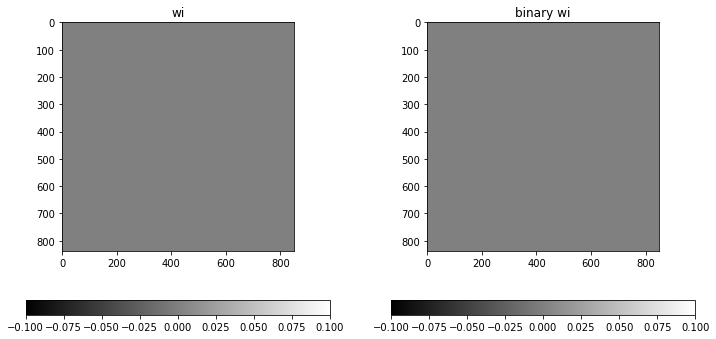

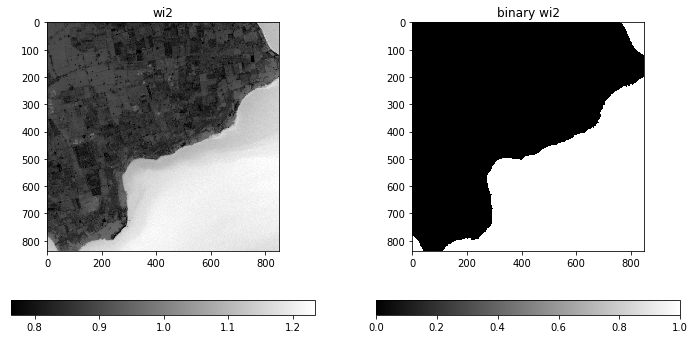

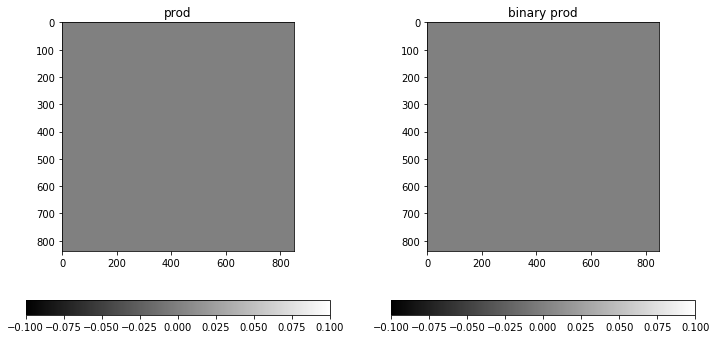

In [151]:
_channels = tuple(channels) + ('wi', 'wi2', 'prod')

for i, image_id in enumerate(dataset):
    i += count
    print "--", image_id, i, "/", len(dataset)
    plt_st(12,6)
    plt.subplot(121)
    display_img_1b(y_true_list[i])
    plt.title("Label")
    plt.subplot(122)
    display_img_1b(water_detector(rad_indcs_imgs[i]))
    m = 1 
    for j in range(rad_indcs_imgs[i].shape[2]):
        if j % m == 0:
            plt_st(12,6)
        plt.subplot(1,2, (j) % m + 1)
        plt.title("%s" % _channels[j])
        display_img_1b(rad_indcs_imgs[i][:,:,j])
        
        plt.subplot(1,2, (j) % m + 2)
        t1, t2, size, iters = params[j]
        bin_img = binarize(rad_indcs_imgs[i][:,:,j], t1, t2, size, iters)
        display_img_1b(bin_img)
        plt.title("binary %s" % _channels[j])
    break
# count+=1

In [19]:
# dataset = water_train
# dataset = waterway_test
#dataset = other_train_ids[3:4]
dataset = ["6110_4_0", ]
rad_indcs_imgs, y_true_list = load_data(dataset, no_labels=True)

-- 6110_4_0 1 / 1


In [20]:
channels

['ndwi2', 'mndwi', 'bi']

In [21]:
from preprocessing_utils import _relu

In [25]:
index = 0

In [26]:
A = rad_indcs_imgs[index][:,:,0]
B = rad_indcs_imgs[index][:,:,2]
#B = B.max() + B.min() - B
#B = (B - B.mean()) / (B.std() + 0.0001)
C = A - B
D = _relu(C)

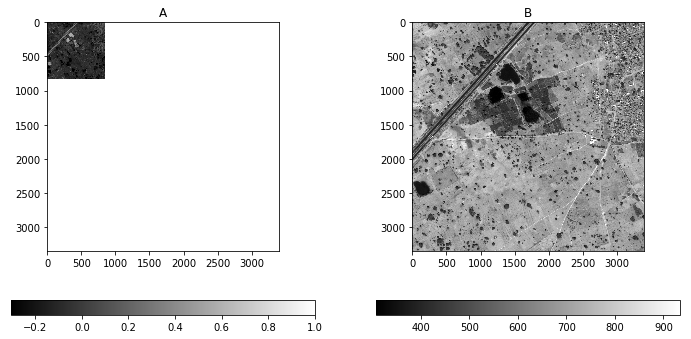

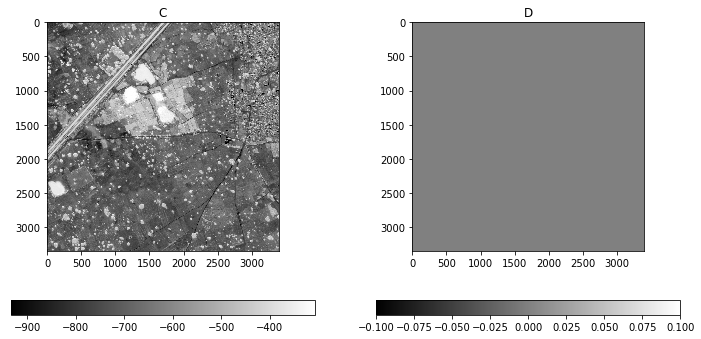

In [27]:
plt_st(12, 6)
plt.subplot(121)
display_img_1b(A)
plt.title("A")
plt.subplot(122)
display_img_1b(B)
plt.title("B")

plt_st(12, 6)
plt.subplot(121)
display_img_1b(C)
plt.title("C")
plt.subplot(122)
display_img_1b(D)
plt.title("D")

In [57]:
# image_id = water_train[0]
# image_id = "6110_4_0"
# image_id = "6110_1_2"
image_id = waterway_test[0]
img_ms = get_image_data(image_id, 'ms')

In [63]:
img_ms = get_image_data(image_id, 'ms')
h = img_ms.shape[0]
w = img_ms.shape[1]
RE_16  = img_ms[:,:,5]
MIR_16 = img_ms[:,:,7]
R_16 = img_ms[:,:,4]

RE  = img_ms[:,:,5].astype(np.float32)
MIR = img_ms[:,:,7].astype(np.float32)
R = img_ms[:,:,4].astype(np.float32)
# return (MIR-RE)/(MIR+RE)*(MIR-R)/(MIR+R)



In [362]:
A =  R / (RE * MIR + 0.00001)

In [363]:
from visu_utils import display_img_8b

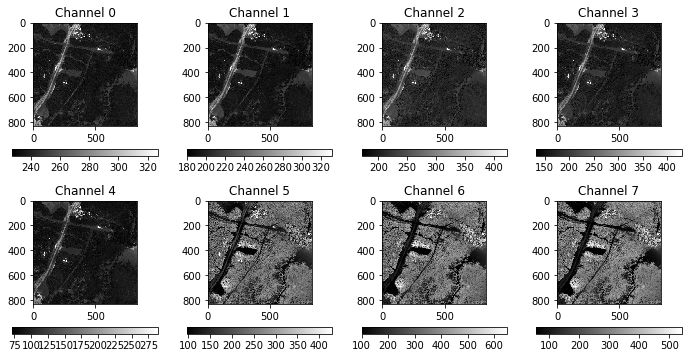

In [58]:
plt_st(12, 6)
display_img_8b(img_ms)

In [375]:
def relu(x):
    x = x.copy()
    x[x < 0] = 0
    return x

def log_poss(x, a=2.0):
    x = x.copy()
    x[x < 0] = 0
    y = x[x > 0]
    x[x > 0] = np.log(1.0 + a*y)
    return x

In [59]:
# A = img_ms[:,:,0].astype(np.float32) - img_ms[:,:,7].astype(np.float32)
# B = img_ms[:,:,1].astype(np.float32) - img_ms[:,:,6].astype(np.float32) 
# C = np.sqrt(relu(A) * relu(B)) /( A + B + 0.0001)
# D = (relu(A) - relu(B))

A = np.sqrt(img_ms[:,:,7].astype(np.float32) * img_ms[:,:,6].astype(np.float32))
B = A / (img_ms[:,:,5].astype(np.float32) + 0.0001)
C = img_ms[:,:,0].astype(np.float32) + img_ms[:,:,1].astype(np.float32)
D = 1.0 / (B + 0.0001)

#A = img_ms[:,:,0].astype(np.float32) - img_ms[:,:,7].astype(np.float32)
#B = img_ms[:,:,1].astype(np.float32) - img_ms[:,:,6].astype(np.float32) 
#C = np.sqrt(relu(A) * relu(B))
#D = C / (img_ms[:,:,5].astype(np.float32) + 0.0001)

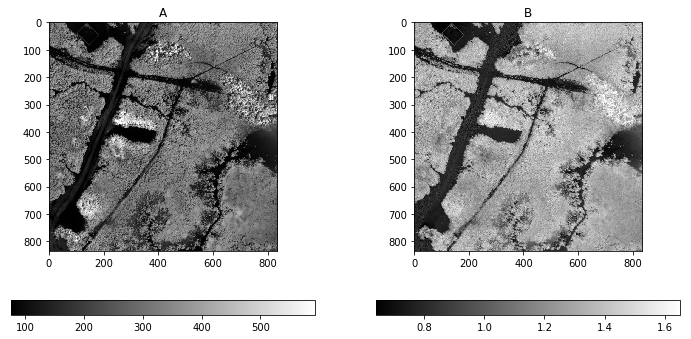

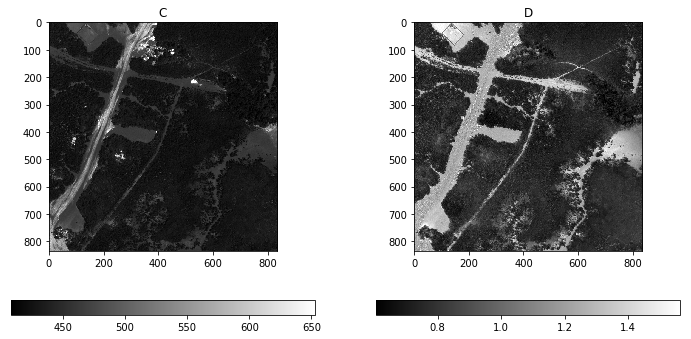

In [60]:
plt_st(12, 6)
plt.subplot(121)
display_img_1b(A)
plt.title("A")
plt.subplot(122)
display_img_1b(B)
plt.title("B")

plt_st(12, 6)
plt.subplot(121)
display_img_1b(C)
plt.title("C")
plt.subplot(122)
display_img_1b(D)
plt.title("D")